<font color="#CA3532"><h1 align="left">TFM: Evaluación de daños por terremotos.</h1></font>
<font color="#CA3532"><h3 align="left">PASO 6.2: Análisis de imágenes: MobileNetV2</h3></font>
<font color="#6E6E6E"><h3 align="right">Pilar Campos López</h3></font> 
<font color="#6E6E6E"><h3 align="right">Silvia Saenz</h3></font> 
<font color="#6E6E6E"><h3 align="right">Ana de Antonio</h3></font> 

## **Transfer Learning**

https://keras.io/applications/

Redes preentrenadas que se pueden descargar directamente en Keras:

* Xception
* VGG16
* VGG19
* ResNet
* ResNetV2
* InceptionV3
* InceptionResNetV2
* MobileNet
* MobileNetV2
* DenseNet
* NASNet

Algunas requieren un tamaño de imagen de entrada fijo, otras no.

In [ ]:
COLAB = True

In [ ]:
#!pip install pillow==8.0.0

In [ ]:
if COLAB:
    %tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
# En parte de:
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from glob import glob

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

%matplotlib inline

Using TensorFlow backend.


In [ ]:
!ls

sample_data


In [ ]:
if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='1EETTDTH5Wv-hZ1tKDpGHYPvAGPQ51gC6',
                                        dest_path='./seg_train.zip', unzip=True)
    gdd.download_file_from_google_drive(file_id='1UI8dSvyJ4OVT7NiF4cYdoAfjYH6Lj76D',
                                        dest_path='./seg_test.zip', unzip=True)
    

    #https://drive.google.com/file/d/1EETTDTH5Wv-hZ1tKDpGHYPvAGPQ51gC6/view?usp=sharing

    #https://drive.google.com/file/d/1UI8dSvyJ4OVT7NiF4cYdoAfjYH6Lj76D/view?usp=sharing

Unzipping...Done.
Unzipping...Done.


In [ ]:
!ls

sample_data  seg_test  seg_test.zip  seg_train	seg_train.zip


In [ ]:
!ls seg_train

mild  none  severe


In [ ]:
!ls seg_test

mild  none  severe


In [ ]:
!ls seg_train/severe/

nepal_eq_severe_im_10000.jpg  nepal_eq_severe_im_24778.jpg
nepal_eq_severe_im_10004.jpg  nepal_eq_severe_im_24782.jpg
nepal_eq_severe_im_10007.jpg  nepal_eq_severe_im_24785.jpg
nepal_eq_severe_im_1000.jpg   nepal_eq_severe_im_24798.jpg
nepal_eq_severe_im_10015.jpg  nepal_eq_severe_im_24801.jpg
nepal_eq_severe_im_10016.jpg  nepal_eq_severe_im_24802.jpg
nepal_eq_severe_im_1004.jpg   nepal_eq_severe_im_24834.jpg
nepal_eq_severe_im_1005.jpg   nepal_eq_severe_im_24858.jpg
nepal_eq_severe_im_1009.jpg   nepal_eq_severe_im_24878.jpg
nepal_eq_severe_im_100.jpg    nepal_eq_severe_im_24880.jpg
nepal_eq_severe_im_1017.jpg   nepal_eq_severe_im_24889.jpg
nepal_eq_severe_im_1018.jpg   nepal_eq_severe_im_24897.jpg
nepal_eq_severe_im_101.jpg    nepal_eq_severe_im_24901.jpg
nepal_eq_severe_im_10206.jpg  nepal_eq_severe_im_24905.jpg
nepal_eq_severe_im_10216.jpg  nepal_eq_severe_im_24927.jpg
nepal_eq_severe_im_10218.jpg  nepal_eq_severe_im_24929.jpg
nepal_eq_severe_im_10225.jpg  nepal_eq_severe_im_24930.j

In [ ]:
ficheros = glob("./seg_train/mild/*")
ficheros[0]

In [ ]:
imagen = load_img(ficheros[1])
imagen

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
imagen.size

(1580, 1110)

In [ ]:
train_data_dir = 'seg_train'
validation_data_dir = 'seg_test'
test_data_dir = 'seg_test'

batch_size = 16

Para ver opciones:

https://keras.io/api/preprocessing/image/#imagedatagenerator-class


In [ ]:

# data augmentation:

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest',
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

In [ ]:
imagen_num = np.array([img_to_array(imagen)])

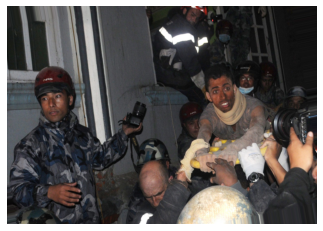

In [ ]:
plt.imshow(train_datagen.flow(imagen_num)[0][0])
plt.axis("off");

## **Red base**

https://keras.io/api/applications/

http://josephpcohen.com/w/visualizing-cnn-architectures-side-by-side-with-mxnet/

In [ ]:
# dimensiones a las que vamos a llevar las imágenes
img_width, img_height = 150, 150

normed_dims = (img_height, img_width)

In [ ]:
normed_dims

(150, 150)

In [ ]:
#from keras.applications.inception_v3 import InceptionV3
#base_model = InceptionV3(weights='imagenet', include_top=False)
#preprocess_input = lambda x:x/255.

In [ ]:
#from keras.applications.resnet50 import preprocess_input
#from keras.applications.resnet50 import ResNet50
#base_model = ResNet50(include_top=False, input_shape=normed_dims + (3,))

In [ ]:
from keras.applications.mobilenet_v2 import preprocess_input
from keras.applications.mobilenet_v2 import MobileNetV2
base_model = MobileNetV2(include_top=False, input_shape=normed_dims + (3,))

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
len(base_model.layers)

In [ ]:
#base_model.summary()

In [ ]:
# sparse_categorical_crossentropy

#building: 0
# 1,0,0,0,0,0

# forest': 1
# 0,1,0,0,0,0

# glacier: 2
# 0,0,1,0,0,0

# mountain: 3
# 0,0,0,1,0,0

# sea: 4,
# 0,0,0,0,1,0

# street: 5
# 0,0,0,0,0,1

In [ ]:
# capas que añado:

aux = base_model.output
aux = GlobalAveragePooling2D()(aux)
#aux = Flatten(input_shape = (2048,))(aux)
aux = Dense(9, activation='relu',
            #kernel_regularizer=regularizers.l2(0.01) # 0.1, 0.01, 0.001
            )(aux)
aux = Dense(3, activation="softmax")(aux)
model = Model(input=base_model.input, output=aux)

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',
              metrics=["acc"])

In [ ]:
model.summary()

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

#if COLAB:
#    display(SVG(model_to_dot(model, show_shapes=True,dpi=72).create(prog='dot', format='svg')))
#else:
#    display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

In [ ]:
train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function = preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen  = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

In [ ]:
validation_data_dir, normed_dims

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=True,
    class_mode='sparse')

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='sparse')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='sparse')

In [ ]:
train_generator.class_indices

In [ ]:
number_train_samples = train_generator.n
number_val_samples   = validation_generator.n
number_test_samples  = test_generator.n

number_train_samples, number_val_samples, number_test_samples

In [ ]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [ ]:
acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []

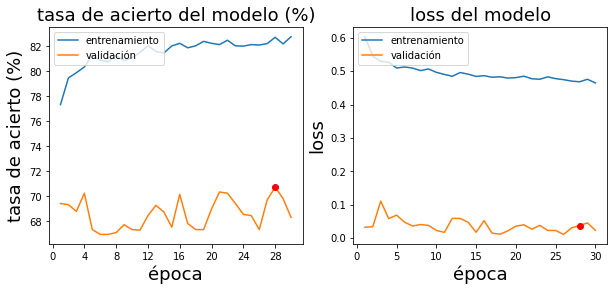

In [ ]:
epochs = 30

modelpath="model_current_best_parte3.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_acc', verbose=1,
                              save_best_only=True,
                              mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]
for e in range(epochs):
    history = model.fit_generator(generator = train_generator, 
                                  steps_per_epoch=number_train_samples // batch_size,
                                  epochs=1,
                                  callbacks=callbacks_list,
                                  verbose=1,
                                  shuffle = True,
                                  validation_data=validation_generator,
                                  validation_steps=number_val_samples // batch_size
                                  )
    
    if history.history['val_acc'][-1] > best_val_acc:
        print("Validation accuracy improved from",
            best_val_acc, 'to', history.history['val_acc'])
        print("saving weights")
        best_val_acc = history.history['val_acc'][-1]
    
    acum_tr_acc.append(history.history['acc'][0])
    acum_val_acc.append(history.history['val_acc'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [ ]:
model = load_model(modelpath)

## **Resultados obtenidos**

In [ ]:
scores_tr = model.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_val = model.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()

scores_te = model.evaluate(test_generator)
print('Test loss     :', scores_te[0])
print('Test accuracy :', scores_te[1])

 91/560 [===>..........................] - ETA: 1:43

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


560/560 [==============================] - 126s 225ms/step
Train loss    : 0.5397031903266907
Train accuracy: 0.7617558240890503

130/130 [==============================] - 21s 160ms/step
Val loss    : 0.03246290981769562
Val accuracy: 0.7094756960868835

130/130 [==============================] - 21s 158ms/step
Test loss     : 0.03246290981769562
Test accuracy : 0.7094756960868835


In [ ]:
y_real = test_generator.classes
y_pred_proba = model.predict_generator(test_generator)

In [ ]:
y_real[:5]

array([0, 0, 0, 0, 0], dtype=int32)

In [ ]:
y_pred_proba[:5]

array([[7.9449899e-02, 5.9168078e-02, 8.6138195e-01],
       [1.5080932e-01, 1.8106908e-01, 6.6812158e-01],
       [1.3640425e-01, 7.3812217e-02, 7.8978348e-01],
       [1.1384008e-01, 9.6699618e-02, 7.8946030e-01],
       [1.7385600e-03, 3.7055425e-04, 9.9789089e-01]], dtype=float32)

In [ ]:
test_generator.class_indices

{'mild': 0, 'none': 1, 'severe': 2}

In [ ]:
num2class = {test_generator.class_indices[x]:x  for x in test_generator.class_indices.keys()}
num2class

{0: 'mild', 1: 'none', 2: 'severe'}

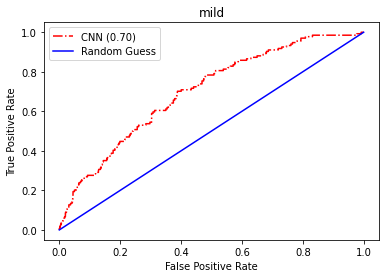

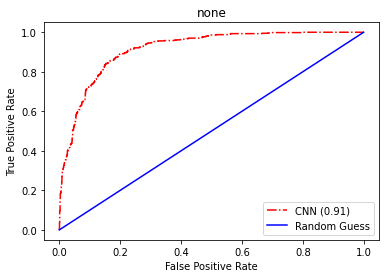

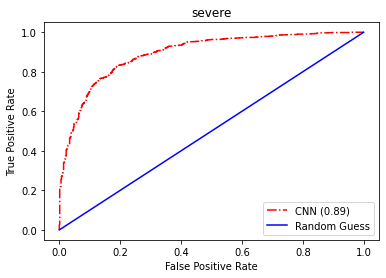

In [ ]:
for clase in range(3):
    nombre_clase = num2class[clase]

    fpr, tpr, thresholds = roc_curve(y_real==clase, y_pred_proba[:,clase])
    fig, ax1 = plt.subplots(1,1)
    ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
    ax1.set_title(nombre_clase)
    ax1.legend()
    plt.show()

## **Visualización de ejemplos de test**

In [ ]:
test_datagen2 = ImageDataGenerator(dtype='float32')

test_generator2 = test_datagen2.flow_from_directory(
    test_data_dir,
    target_size=normed_dims,
    batch_size=test_generator.n,
    shuffle=False,
    class_mode='sparse')

Found 2079 images belonging to 3 classes.


In [ ]:
test_generator2.reset()
X_te, y_te = test_generator2.next()

In [ ]:
test_generator2.class_indices

{'mild': 0, 'none': 1, 'severe': 2}

In [ ]:
y_te

array([0., 0., 0., ..., 2., 2., 2.], dtype=float32)

Clase real: mild
mild: 15% none: 18% severe: 66% 


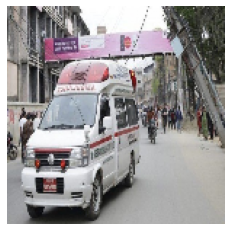

In [ ]:
ind_te1 = 1

image = X_te[ind_te1].copy()

print("Clase real:", num2class[y_te[ind_te1]])
plt.imshow(image/255, cmap='jet')
plt.axis("off")
p = model.predict(preprocess_input(np.array([image])))[0]
cadena = ""
for i in range(len(num2class)):
    cadena = cadena + "{}: {}% ".format(num2class[i], int(100*p[i]))
print(cadena)

In [ ]:
!ls

model_current_best_parte3.h5  seg_test	    seg_train
sample_data		      seg_test.zip  seg_train.zip


In [ ]:
#from google.colab import files
#files.download('./model_current_best_parte3.h5')

Se presentan tres tipos de daños, el modelo recono mejor las fotografías con daño severo o no daño, la clase intermedia no la distingue muy bien, por lo que se aprecia suele meter el daño mild en severe.